# IBM Applied Data Science Capstone Project by Coursera

## Week 5 Final Report

### Opening a Grocery Store in Toronto, Canada

**Goal:** 

* Build a dataframe of neighborhoods and boroughs in Toronto, Canada.
* Obtain the geographical coordinates of the neighborhoods.
* Get the venue data for the neighborhoods from Foursquare API.
* Analyze and cluster the neighborhoods by kmeans clustering.
* Select the best cluster to open a new grocery store.

## 1. Import libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import geocoder # to get coordinates

import requests # library to handle requests
from bs4 import BeautifulSoup # library to parse HTML and XML documents

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

print("Libraries imported.")

Libraries imported.


## 2. Data acquisition and cleaning

## 2.1 Data Sources

a) Toronto City data. 
* Data source: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M
* Description: The data contains the postal code, borough & the name of all the neighborhoods present in Toronto.

b) Geospace data for each neighborhood in Toronto City.
* Data source: https://cocl.us/Geospatial_data csv file
* Description: The data contains the geographical coordinates i.e. latitudes and longitudes of the neighborhoods. 

c) Venue data, particularly data related to grocery store. 
* Data source: https://developer.foursquare.com/docs
* Description: FourSquare’s explore API gives details such as names, categories and locations (latitude and longitude).


## 2.2 Data Preparation & Cleaning 

**a) Scraping Toronto Neighborhoods table from the following Wikipedia page, “List of Postal code of Canada: M”**

Assumptions made to attain the below DataFrame:

- Dataframe will consist of three columns: PostalCode, Borough, and Neighborhood
- Only the cells that have an assigned borough will be processed. Borough that is not assigned are ignored.
- More than one neighborhood can exist in one postal code area. For example, in the table on the Wikipedia page, you will notice that M5A is listed twice and has two neighborhoods: Harbourfront and Regent Park. These two rows will be combined into one row with the neighborhoods separated with a comma as shown in row 11 in the above table.
- If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough.
wikipedia - package is used to scrape the data from wiki.

In [2]:
import wikipedia as wp

html = wp.page("List of postal codes of Canada: M").html().encode("UTF-8")
df = pd.read_html(html, header = 0)[0]
df.head()

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


In [3]:
#Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.
df = df[df.Borough != 'Not assigned']
df = df.rename(columns={'Postcode': 'Postalcode'})

#If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough. 
#So for the 9th cell in the table on the Wikipedia page, the value of the Borough and the Neighborhood columns will be Queen's Park.
for index, row in df.iterrows():
    if row['Neighbourhood'] == 'Not assigned':
        row['Neighbourhood'] = row['Borough']


df.head()

,Postalcode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M6A,North York,Lawrence Heights
6,M6A,North York,Lawrence Manor


In [5]:
# Group by Neighbourhoods
df = df.groupby(['Borough','Postalcode'])['Neighbourhood'].apply(list).apply(lambda x:', '.join(x)).to_frame().reset_index()
df.head()

,Borough,Postalcode,Neighbourhood
0,Central Toronto,M4N,Lawrence Park
1,Central Toronto,M4P,Davisville North
2,Central Toronto,M4R,North Toronto West
3,Central Toronto,M4S,Davisville
4,Central Toronto,M4T,"Moore Park, Summerhill East"


**b) Adding geographical coordinates to the neighborhoods**

Next is adding the geographical coordinates to these neighborhoods. To do so, extracting the data present in the Geospatial Cordinates csv file and combining it with the existing neighborhood dataframe by merging them both based on the postal code.

In [6]:
df_lat_long = pd.read_csv("./Geospatial_Coordinates.csv")
df_lat_long.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [7]:
# Renaming the columns to match the existing dataframe
df_lat_long = df_lat_long.rename(columns={'Postal Code': 'Postalcode'})
df_lat_long.head()

,Postalcode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [8]:
# Merging both the dataframe "df" and "df_lat_long"into one by matching on the postal code.
df_toronto = pd.merge(df, df_lat_long, how='left', left_on = 'Postalcode', right_on = 'Postalcode')

# Renaming the columns to match the existing dataframe
df_toronto = df_toronto.rename(columns={'Neighbourhood':'Neighborhood'})

df_toronto.head()

,Borough,Postalcode,Neighborhood,Latitude,Longitude
0,Central Toronto,M4N,Lawrence Park,43.728020,-79.388790
1,Central Toronto,M4P,Davisville North,43.712751,-79.390197
2,Central Toronto,M4R,North Toronto West,43.715383,-79.405678
3,Central Toronto,M4S,Davisville,43.704324,-79.388790
4,Central Toronto,M4T,"Moore Park, Summerhill East",43.689574,-79.383160


In [9]:
#Use geopy library to get the latitude and longitude values of toronto.

address = 'Toronto'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


**c) Get location data using Foursquare**

Foursquare API is very useful online application used my many developers & other application like Uber etc. The API returns a JSON file and later we need to turn that into a data-frame. 

**Use the Foursquare API to explore the neighborhoods**

# 3. Visualization and Exploratory Data Analysis

## 3.1 Exploring the neighborhoods using Foresquare API

**Now, let's get the most popular 100 venues that are in within a radius of 1000 meters.**

We define a function to intract with FourSquare API and get top 100 venues within a radius of 1000 metres for a given latitude and longitude. Below function will return us the venue names, category, venue latitude and venue logitude.

In [11]:
radius=1000
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius)
results = requests.get(url).json()

#Function to get the category

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']

    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    
    
from pandas.io.json import json_normalize

venues = results['response']['groups'][0]['items']

nearby_venues = json_normalize(venues) # flatten JSON

filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()


,name,categories,lat,lng
0,Downtown Toronto,Neighborhood,43.653232,-79.385296
1,Japango,Sushi Restaurant,43.655268,-79.385165
2,Rolltation,Japanese Restaurant,43.654918,-79.387424
3,Nathan Phillips Square,Plaza,43.652270,-79.383516
4,Sansotei Ramen 三草亭,Ramen Restaurant,43.655157,-79.386501


Now we can explore the nearby venues!

In [12]:
# Creating a function to find the nearby venues on all the neighborhoods in Toronto


def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
         #url to fetch data from foursquare api
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # get all the data
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Latitude', 
                  'Longitude', 
                  'Venue Name', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


In [13]:
#Running the above function on each neighborhood of toronto and creating a new dataframe called toronto_venues .
LIMIT=100
toronto_venues = getNearbyVenues(names=df_toronto['Neighborhood'],
                                   latitudes=df_toronto['Latitude'],
                                   longitudes=df_toronto['Longitude'],
                                  )

Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park, Summerhill East
Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West
Roselawn
Forest Hill North, Forest Hill West
The Annex, North Midtown, Yorkville
Rosedale
Cabbagetown, St. James Town
Church and Wellesley
Harbourfront
Ryerson, Garden District
St. James Town
Berczy Park
Central Bay Street
Adelaide, King, Richmond
Harbourfront East, Toronto Islands, Union Station
Design Exchange, Toronto Dominion Centre
Commerce Court, Victoria Hotel
Harbord, University of Toronto
Chinatown, Grange Park, Kensington Market
CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara
Stn A PO Boxes 25 The Esplanade
First Canadian Place, Underground city
Christie
Queen's Park
The Beaches
The Danforth West, Riverdale
The Beaches West, India Bazaar
Studio District
Business Reply Mail Processing Centre 969 Eastern
Woodbine Gardens, Parkview Hill
Woodbine Heights
Leaside
Thorncl

In [14]:
toronto_venues.head(5)

,Neighborhood,Latitude,Longitude,Venue Name,Venue Latitude,Venue Longitude,Venue Category
0,Lawrence Park,43.72802,-79.38879,Lawrence Park Ravine,43.726963,-79.394382,Park
1,Lawrence Park,43.72802,-79.38879,Granite Club,43.733043,-79.381986,Gym / Fitness Center
2,Lawrence Park,43.72802,-79.38879,Tim Hortons,43.727324,-79.379563,Coffee Shop
3,Lawrence Park,43.72802,-79.38879,Granite Club President's Lounge,43.733005,-79.382059,Café
4,Lawrence Park,43.72802,-79.38879,Glendon Bookstore,43.727024,-79.378976,Bookstore


**Let's check how many venues were returned for each neighorhood**

In [15]:
toronto_venues.groupby('Neighborhood').count().head()

,Latitude,Longitude,Venue Name,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide, King, Richmond",100,100,100,100,100,100
Agincourt,49,49,49,49,49,49
"Agincourt North, L'Amoreaux East, Milliken, Steeles East",29,29,29,29,29,29
"Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown",19,19,19,19,19,19
"Alderwood, Long Branch",28,28,28,28,28,28


**Let's find out how many unique categories can be curated from all the returned venues**

In [16]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 328 uniques categories.


In [17]:
# print out the list of first 30 categories
toronto_venues['Venue Category'].unique()[:30]

array(['Park', 'Gym / Fitness Center', 'Coffee Shop', 'Café', 'Bookstore',
       'Trail', 'College Quad', 'College Gym', 'Food & Drink Shop',
       'Supermarket', 'Tea Room', 'Bakery', 'Italian Restaurant',
       'Yoga Studio', 'Brewery', 'Breakfast Spot', 'Sushi Restaurant',
       'Vegetarian / Vegan Restaurant', 'Dessert Shop', 'Pizza Place',
       'Taco Place', 'Wine Bar', 'Ramen Restaurant', 'Deli / Bodega',
       'Gym', 'Grocery Store', 'Track', 'Plaza', 'Vietnamese Restaurant',
       'Gastropub'], dtype=object)

From the above analysis, it is found that there are 328 unique categories in which Grocery Store is one of them. Next, we will do one hot encoding for getting dummies of venue category. Then, we will calculate mean of all venue groupby there neighborhoods.

**Lets, analyze each neighbourhood**

In [18]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

print(toronto_onehot.shape)
toronto_onehot.head()


(4907, 328)


,Zoo,Accessories Store,Afghan Restaurant,Airport,Airport Lounge,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,College Quad,College Rec Center,College Stadium,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Dentist's Office,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Entertainment Service,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fireworks Store,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,Frame Store,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hong Kong Restaurant,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundry Service,Light Rail Station,Lighting Store,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Photography Lab,Pide Place,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,River,Road,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Ski Area,Ski Chalet,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,South American Restaurant,Southe

**Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category**

In [19]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
print(toronto_grouped.shape)
toronto_grouped.head()

(101, 328)


,Neighborhood,Zoo,Accessories Store,Afghan Restaurant,Airport,Airport Lounge,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,College Quad,College Rec Center,College Stadium,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Dentist's Office,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Entertainment Service,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fireworks Store,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,Frame Store,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hong Kong Restaurant,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundry Service,Light Rail Station,Lighting Store,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Photography Lab,Pide Place,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,River,Road,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Ski Area,Ski Chalet,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,South American Restaurant,Southe

**Let's also count venues of each category in each neighborhood**

In [23]:
venue_counts = toronto_onehot.groupby('Neighborhood').sum()
venue_counts.head(5)

,Zoo,Accessories Store,Afghan Restaurant,Airport,Airport Lounge,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,College Quad,College Rec Center,College Stadium,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Dentist's Office,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Entertainment Service,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fireworks Store,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,Frame Store,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hong Kong Restaurant,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundry Service,Light Rail Station,Lighting Store,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Photography Lab,Pide Place,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,River,Road,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Ski Area,Ski Chalet,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,South American Restaurant,Southern / Soul Foo

**Let's also create a new DataFrame for Grocery Store data only**

In [24]:
toronto_grocerystore = toronto_grouped[["Neighborhood","Grocery Store"]]
toronto_grocerystore.head()

,Neighborhood,Grocery Store
0,"Adelaide, King, Richmond",0.000000
1,Agincourt,0.000000
2,"Agincourt North, L'Amoreaux East, Milliken, St...",0.034483
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",0.157895
4,"Alderwood, Long Branch",0.035714


**Let's find out the top 20 categories in Toronto**

In [25]:
venue_counts_described = venue_counts.describe().transpose()

venue_top10 = venue_counts_described.sort_values('max', ascending=False)[0:20]
venue_top10


,count,mean,std,min,25%,50%,75%,max
Coffee Shop,101.0,3.683168,3.193527,0.0,2.0,3.0,6.0,15.0
Greek Restaurant,101.0,0.386139,1.448933,0.0,0.0,0.0,0.0,13.0
Korean Restaurant,101.0,0.287129,1.358945,0.0,0.0,0.0,0.0,12.0
Café,101.0,2.049505,2.706940,0.0,0.0,1.0,3.0,10.0
Indian Restaurant,101.0,0.455446,1.034647,0.0,0.0,0.0,1.0,8.0
Bar,101.0,0.732673,1.554935,0.0,0.0,0.0,1.0,8.0
Chinese Restaurant,101.0,0.544554,1.100225,0.0,0.0,0.0,1.0,7.0
Italian Restaurant,101.0,1.138614,1.496861,0.0,0.0,1.0,2.0,7.0
Pub,101.0,0.594059,1.159122,0.0,0.0,0.0,1.0,7.0
Hotel,101.0,0.653465,1.526012,0.0,0.0,0.0,0.0,7.0


From the above top 20 categories,it is being analyzed that Grocery store is also among top 20 categories.

The top 20 ‘Venue Categories’ can also be found by counting their occurrences. This analysis is depicted below which shows that ‘ Grocery Store’is among the top 20.

In [27]:
Toronto_Venues_Top20 = toronto_venues['Venue Category'].value_counts()[0:15].to_frame(name='frequency')
Toronto_Venues_Top20 =Toronto_Venues_Top20.reset_index()
#Toronto_Venues_Top20

Toronto_Venues_Top20.rename(index=str, columns={"index": "Venue_Category", "frequency": "Frequency"}, inplace=True)
Toronto_Venues_Top20

,Venue_Category,Frequency
0,Coffee Shop,372
1,Café,207
2,Park,146
3,Pizza Place,145
4,Restaurant,117
5,Italian Restaurant,115
6,Bakery,103
7,Grocery Store,92
8,Sandwich Place,82
9,Japanese Restaurant,78


** Let's also visualize through barplot**

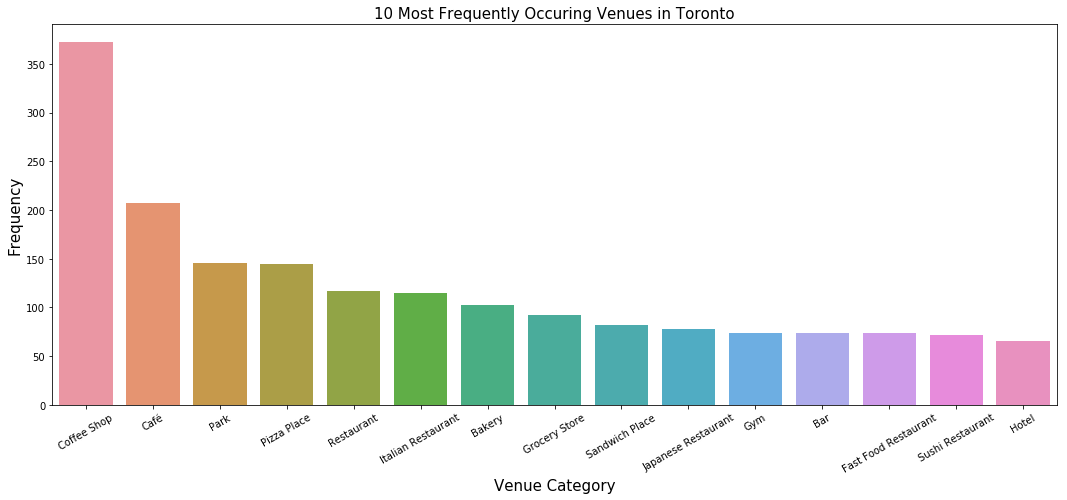

In [29]:
import seaborn as sns
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(18,7))
s=sns.barplot(x="Venue_Category", y="Frequency", data=Toronto_Venues_Top20)
s.set_xticklabels(s.get_xticklabels(), rotation=30)
plt.title('10 Most Frequently Occuring Venues in Toronto', fontsize=15)
plt.xlabel("Venue Category", fontsize=15)
plt.ylabel ("Frequency", fontsize=15)
plt.savefig("Most_Freq_Venues.png", dpi=300)
plt.show()

After we done with the analyzing the neighborhoods, let analyze a map of Toronto with the help of Folium library.

## 3.2 Analyze a map of Toronto with neighborhoods superimposed on top

Drawing an interactive leaflet map using coordinate data and python library Folium.

In [69]:
import folium
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_toronto['Latitude'], df_toronto['Longitude'], df_toronto['Borough'], df_toronto['Neighborhood']):
    label = '{},{}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

Next, lets analyze the relationship between neighborhoods and grocery store

## 3.3 Analyze the relationship between neighborhoods and Grocery Store

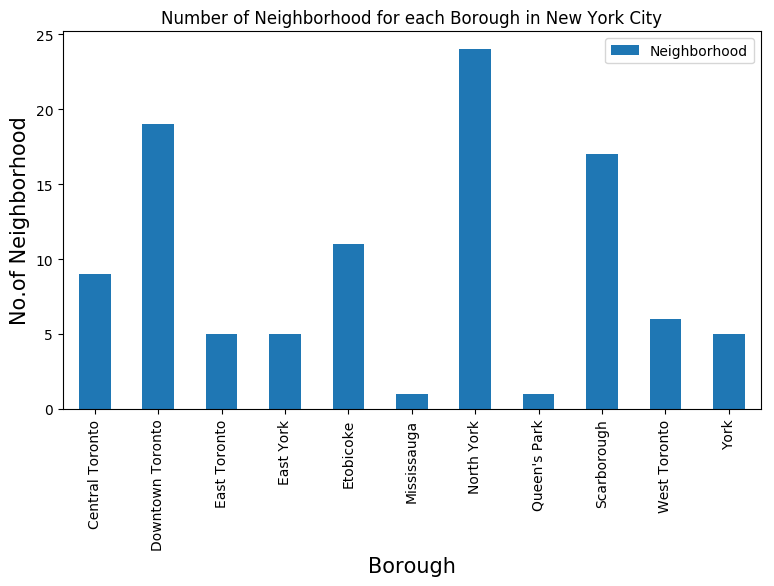

In [32]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
df_toronto.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

From the above visualization, it is observed  that the borough North York has the highest number of neighborhoods. Next, we will prepare borough list that contains Grocery Store data for each Neighborhood.Let's try Bar plot.

In [39]:
toronto_part=toronto_grouped[['Neighborhood', 'Grocery Store']]
toronto_part.max()

,Neighborhood,Grocery Store
0,"Adelaide, King, Richmond",0.000000
1,Agincourt,0.000000
2,"Agincourt North, L'Amoreaux East, Milliken, St...",0.034483
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",0.157895
4,"Alderwood, Long Branch",0.035714
5,"Bathurst Manor, Downsview North, Wilson Heights",0.000000
6,Bayview Village,0.076923
7,"Bedford Park, Lawrence Manor East",0.023256
8,Berczy Park,0.010000
9,"Birch Cliff, Cliffside West",0.000000


** Let's visualize by using bar plot**

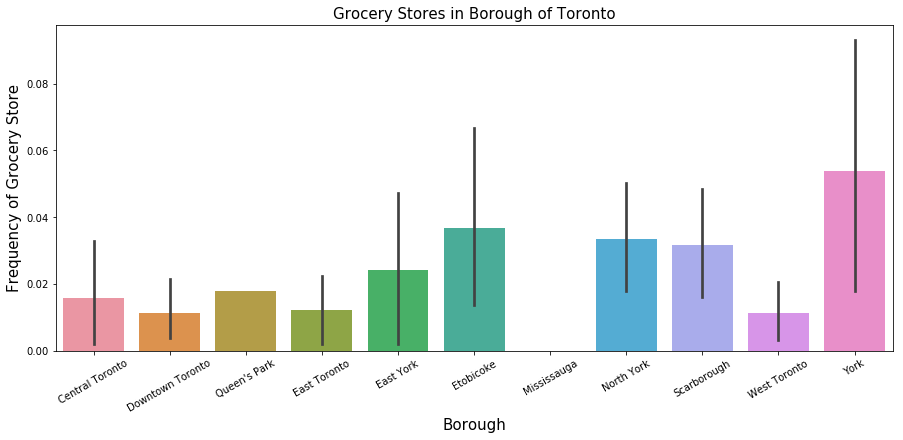

In [36]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(15,6))
s=sns.barplot(y="Grocery Store", x="Borough", data=toronto_merged);
s.set_xticklabels(s.get_xticklabels(), rotation=30)
plt.title('Grocery Stores in Borough of Toronto', fontsize=15)
plt.xlabel("Borough", fontsize=15)
plt.ylabel ("Frequency of Grocery Store", fontsize=15)
plt.show()

From the above visualization, it is being observed that the borough "York" has the highest number of grocery stores. This analysis can further be verified by extracting the information from the dataframe toronto_grouped and the dataframe toronto_merged. The information we get is which borough and which neighborhood has the maximum number of Grocery stores. Thus, the analysis showed that borough "York", and its neighbourhood  "York Mills West" have max number of Grocery Store.

In [87]:
toronto_part=toronto_grouped[['Neighborhood', 'Grocery Store']]
toronto_part.max()

Neighborhood     York Mills West
Grocery Store             0.1875
dtype: object

In [88]:
toronto_merged = pd.merge(df_toronto, toronto_part, on='Neighborhood')
toronto_merged.max()

Borough                     York
Postalcode                   M9W
Neighborhood     York Mills West
Latitude                 43.8153
Longitude               -79.1605
Grocery Store             0.1875
dtype: object

Next, we will look into the predictive modeling. In the predictive modelling we are going to use Clustering techniques since this is analysis of unlabelled data. K-Means clustering is used to perform the analysis of the data at hand.

# 4. Predictive Modeling

## 4.1 Cluster the  Neighborhoods of Toronto:

First step in K-means clustering is to identify best K value meaning the number of clusters in a given dataset. To do so we are going to use the elbow method on the Toronto dataset with Grocery Store percentage (i.e.toronto_grocerystore dataframe).

**Determine the optimal number of clusters for k-means clustering**

The Elbow Method - calculate the sum of squared distances of samples to their closest cluster center for different values of k. The value of k after which there is no siginificant decrease in sum of squared distances is choosen.

In [91]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'python -m pip install --upgrade pip' command.


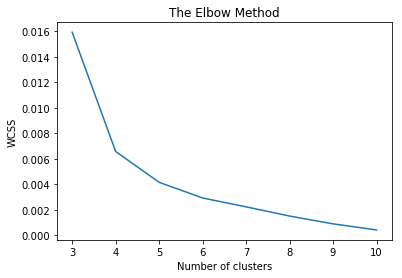

In [40]:
# Using the elbow method to find the optimal number of clusters
# import k-means from clustering stage
from sklearn.cluster import KMeans

# Matplotlib and associated plotting modules
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

toronto_clustering = toronto_part.drop('Neighborhood', 1)


wcss = []

for i in range(3, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter= 50)
    kmeans.fit(toronto_clustering)
    wcss.append(kmeans.inertia_)
plt.plot(range(3, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') 
plt.show()



**After analyzing using elbow method it is found that K = 5 is the best value. Clustering the Toronto Neighborhood Using K-Means with K =5*

## 4.2 Examining the Clusters

We have total of 6 clusters such as 0,1,2,3,4,5. Let us examine one after the other.

Run k-means to cluster the neighborhood into 5 clusters.

In [41]:
#set number of clusters
kclusters = 5

toronto_clustering = toronto_part.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([2, 2, 0, 3, 0, 2, 1, 0, 2, 2, 4, 2, 2, 2, 2, 2, 4, 2, 0, 2, 2, 4, 2,
       0, 0, 2, 4, 2, 2, 2, 0, 3, 2, 2, 2, 0, 2, 4, 3, 2, 1, 2, 2, 0, 2, 2,
       2, 3, 1, 0, 2, 2, 0, 2, 4, 4, 2, 2, 4, 2, 0, 4, 0, 2, 4, 2, 1, 4, 0,
       2, 2, 2, 0, 0, 0, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 0, 0, 0, 2, 0, 2, 4,
       1, 2, 2, 0, 1, 2, 2, 2, 4])

In [43]:
# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
toronto_merged = toronto_part.copy()

# add clustering labels
toronto_merged["Cluster Labels"] = kmeans.labels_
toronto_merged.head()

,Neighborhood,Grocery Store,Cluster Labels
0,"Adelaide, King, Richmond",0.000000,2
1,Agincourt,0.000000,2
2,"Agincourt North, L'Amoreaux East, Milliken, St...",0.034483,0
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",0.157895,3
4,"Alderwood, Long Branch",0.035714,0


In [44]:
# merge toronto_merged with df_torontoto add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(df_toronto.set_index("Neighborhood"), on="Neighborhood")

print(toronto_merged.shape)
toronto_merged.head() # check the last columns!

(102, 7)


,Neighborhood,Grocery Store,Cluster Labels,Borough,Postalcode,Latitude,Longitude
0,"Adelaide, King, Richmond",0.000000,2,Downtown Toronto,M5H,43.650571,-79.384568
1,Agincourt,0.000000,2,Scarborough,M1S,43.794200,-79.262029
2,"Agincourt North, L'Amoreaux East, Milliken, St...",0.034483,0,Scarborough,M1V,43.815252,-79.284577
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",0.157895,3,Etobicoke,M9V,43.739416,-79.588437
4,"Alderwood, Long Branch",0.035714,0,Etobicoke,M8W,43.602414,-79.543484


In [45]:
# sort the results by Cluster Labels
print(toronto_merged.shape)
toronto_merged.sort_values(["Cluster Labels"], inplace=True)
toronto_merged

(102, 7)


,Neighborhood,Grocery Store,Cluster Labels,Borough,Postalcode,Latitude,Longitude
18,Cedarbrae,0.032258,0,Scarborough,M1H,43.773136,-79.239476
68,"Newtonbrook, Willowdale",0.029412,0,North York,M2M,43.789053,-79.408493
52,"High Park, The Junction South",0.020000,0,West Toronto,M6P,43.661608,-79.464763
24,"Clarks Corners, Sullivan, Tam O'Shanter",0.027027,0,Scarborough,M1T,43.781638,-79.304302
23,"Clairlea, Golden Mile, Oakridge",0.032258,0,Scarborough,M1L,43.711112,-79.284577
43,"Fairview, Henry Farm, Oriole",0.022727,0,North York,M2J,43.778517,-79.346556
74,Queen's Park,0.017857,0,Queen's Park,M9A,43.667856,-79.532242
74,Queen's Park,0.017857,0,Downtown Toronto,M7A,43.662301,-79.389494
72,"Parkdale, Roncesvalles",0.020000,0,West Toronto,M6R,43.648960,-79.456325
85,"The Annex, North Midtown, Yorkville",0.030000,0,Central Toronto,M5R,43.672710,-79.405678


**Finally, let's visualize the resulting clusters**

In [68]:
import folium
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

**Cluster 0**

In [54]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0]

,Neighborhood,Grocery Store,Cluster Labels,Borough,Postalcode,Latitude,Longitude
18,Cedarbrae,0.032258,0,Scarborough,M1H,43.773136,-79.239476
68,"Newtonbrook, Willowdale",0.029412,0,North York,M2M,43.789053,-79.408493
52,"High Park, The Junction South",0.020000,0,West Toronto,M6P,43.661608,-79.464763
24,"Clarks Corners, Sullivan, Tam O'Shanter",0.027027,0,Scarborough,M1T,43.781638,-79.304302
23,"Clairlea, Golden Mile, Oakridge",0.032258,0,Scarborough,M1L,43.711112,-79.284577
43,"Fairview, Henry Farm, Oriole",0.022727,0,North York,M2J,43.778517,-79.346556
74,Queen's Park,0.017857,0,Queen's Park,M9A,43.667856,-79.532242
74,Queen's Park,0.017857,0,Downtown Toronto,M7A,43.662301,-79.389494
72,"Parkdale, Roncesvalles",0.020000,0,West Toronto,M6R,43.648960,-79.456325
85,"The Annex, North Midtown, Yorkville",0.030000,0,Central Toronto,M5R,43.672710,-79.405678


In [53]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0].count()

Neighborhood      23
Grocery Store     23
Cluster Labels    23
Borough           23
Postalcode        23
Latitude          23
Longitude         23
dtype: int64

Cluster 0 is shown in red color in the map. 

**Cluster 1**

In [56]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1]

,Neighborhood,Grocery Store,Cluster Labels,Borough,Postalcode,Latitude,Longitude
40,"East Birchmount Park, Ionview, Kennedy Park",0.074074,1,Scarborough,M1K,43.727929,-79.262029
80,Scarborough Village,0.083333,1,Scarborough,M1J,43.744734,-79.239476
92,Victoria Village,0.100000,1,North York,M4A,43.725882,-79.315572
6,Bayview Village,0.076923,1,North York,M2K,43.786947,-79.385975
48,"Guildwood, Morningside, West Hill",0.080000,1,Scarborough,M1E,43.763573,-79.188711
75,Rosedale,0.080000,1,Downtown Toronto,M4W,43.679563,-79.377529
96,Willowdale West,0.071429,1,North York,M2R,43.782736,-79.442259
66,"Maryvale, Wexford",0.100000,1,Scarborough,M1R,43.750072,-79.295849


In [58]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1].count()

Neighborhood      8
Grocery Store     8
Cluster Labels    8
Borough           8
Postalcode        8
Latitude          8
Longitude         8
dtype: int64

Cluster 1 is shown in purple color on a map. It has less number of grocery store as compared to Cluster 0.

**Cluster 2**

In [49]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2]

,Neighborhood,Grocery Store,Cluster Labels,Borough,Postalcode,Latitude,Longitude
0,"Adelaide, King, Richmond",0.000000,2,Downtown Toronto,M5H,43.650571,-79.384568
65,"Little Portugal, Trinity",0.000000,2,West Toronto,M6J,43.647927,-79.419750
63,Lawrence Park,0.000000,2,Central Toronto,M4N,43.728020,-79.388790
59,"Kingsview Village, Martin Grove Gardens, Richv...",0.000000,2,Etobicoke,M9R,43.688905,-79.554724
57,Humber Summit,0.000000,2,North York,M9L,43.756303,-79.565963
69,North Toronto West,0.000000,2,Central Toronto,M4R,43.715383,-79.405678
70,Northwest,0.000000,2,Etobicoke,M9W,43.706748,-79.594054
79,"Ryerson, Garden District",0.000000,2,Downtown Toronto,M5B,43.657162,-79.378937
76,Roselawn,0.000000,2,Central Toronto,M5N,43.711695,-79.416936
77,"Rouge, Malvern",0.000000,2,Scarborough,M1B,43.806686,-79.194353


In [59]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2].count()

Neighborhood      54
Grocery Store     54
Cluster Labels    54
Borough           54
Postalcode        54
Latitude          54
Longitude         54
dtype: int64

Cluster 2 has very low number to totally no grocery stores in the neighborhoods. This represents a great opportunity and high potential areas to open new grocery stores as there is very little to no competition from existing stores. It is shown in blue color in the map.

**Cluster 3**

In [50]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3]

,Neighborhood,Grocery Store,Cluster Labels,Borough,Postalcode,Latitude,Longitude
38,Downsview West,0.125000,3,North York,M3L,43.739015,-79.506944
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",0.157895,3,Etobicoke,M9V,43.739416,-79.588437
47,Glencairn,0.121212,3,North York,M6B,43.709577,-79.445073
31,"Del Ray, Keelesdale, Mount Dennis, Silverthorn",0.125000,3,York,M6M,43.691116,-79.476013


In [60]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3].count()

Neighborhood      4
Grocery Store     4
Cluster Labels    4
Borough           4
Postalcode        4
Latitude          4
Longitude         4
dtype: int64

Cluster 3 is shown in green color on map.

**Cluster 4**

In [51]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4]

,Neighborhood,Grocery Store,Cluster Labels,Borough,Postalcode,Latitude,Longitude
91,Thorncliffe Park,0.062500,4,East York,M4H,43.705369,-79.349372
10,"Bloordale Gardens, Eringate, Markland Wood, Ol...",0.058824,4,Etobicoke,M9C,43.643515,-79.577201
55,"Humber Bay Shores, Mimico South, New Toronto",0.050000,4,Etobicoke,M8V,43.605647,-79.501321
21,Christie,0.050000,4,Downtown Toronto,M6G,43.669542,-79.422564
26,"Cloverdale, Islington, Martin Grove, Princess ...",0.066667,4,Etobicoke,M9B,43.650943,-79.554724
54,Hillcrest Village,0.045455,4,North York,M2H,43.803762,-79.363452
37,Downsview Northwest,0.062500,4,North York,M3N,43.761631,-79.520999
67,"Moore Park, Summerhill East",0.065574,4,Central Toronto,M4T,43.689574,-79.383160
64,Leaside,0.048387,4,East York,M4G,43.709060,-79.363452
61,L'Amoreaux West,0.043478,4,Scarborough,M1W,43.799525,-79.318389


In [61]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4].count()

Neighborhood      13
Grocery Store     13
Cluster Labels    13
Borough           13
Postalcode        13
Latitude          13
Longitude         13
dtype: int64

Cluster 4 is shown in yellow color on a map.

## 5. Results

Now, we have reached the end of the analysis. In this section we will report all the findings from the visualization & clustering of the dataset. We have found out that: 
- From the bar plot in visualization section, we found that out of 11 boroughs only East York, Etobicoke, North York , Scarborough & York boroughs have large amount of Grocery stores. However, Central Toronto, Downtown Toronto, Queen's Park, east Toronto, West Toronto & Mississauga have less number of Grocery stores.
- From the visualization section, it is also being analyzed that it wont be a good decision to open a grocery store in York borough and a neighborhood York Mill West due to large amount of grocery stores. Also, from the clustering section, it is being observed that the above specified borough and neighborhood lies in Cluster 4. 
- From the clustering section, we examined that cluster 2  has very low number to totally no grocery stores in the neighborhoods. So it is better idea to open a new grocery store in the neighborhoods which  belongs to cluster 2.
